<a href="https://colab.research.google.com/github/Joeri38/inverse-design/blob/master/Fabry_P%C3%A9rot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro


In this notebook, we perform inverse design of a Fabry-Pérot resonator for the transmission $T(\lambda)$.

In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #to plot all variables in a cell

from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/My Drive/Fulcon 1/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1: Training the neural network

## Setting up data

In [14]:
import numpy as np

#Create resonator parameters

theta_0 = [-70, -60, -50, -40, -30, -15, 0, 15, 30, 40, 50, 60, 70]
n_0 = np.arange(1.05, 3.55, 0.05) #was 1 to 4 in first experiment
l_0 = np.arange(100, 1010,10)
lamb_0 = np.arange(400, 800, 2).astype('float32')

vector = np.array([(i,j,k) for i in theta_0 for j in n_0 for k in l_0])
print("We have {} training samples".format(len(vector)))

We have 59150 training samples


We can compute the transmission spectrum of the Fabry-Pérot resonator using the analytical result

$$ T(\lambda, \theta, n, l) = \frac{1}{1 + F sin^2 (\frac{\delta}{2})} $$ 

where 

$$ F(\theta, n) = \frac{4R}{(1-R)^2}, \hspace{1 cm} \delta(\lambda, \theta, n, l) = \frac{2 \pi n}{\lambda} 2l cos \theta. $$

The angle $\theta$ is the angle inside the material, we call the incident angle $\theta_0$. From Snell's law:

$$  n sin \theta = n_0 sin \theta_0, $$

follows 

$$ cos \theta = \sqrt{1 - \frac{sin^2 \theta_0}{n^2}}. $$

For the reflectivity of TE polarized light, we have 

$$ R = \Bigg[\frac{n cos \theta - cos \theta_0}{n cos \theta + cos \theta_0} \Bigg]^2. $$

In [15]:
# Calculate transmission spectra of the resonator parameters

def cos_mat(theta, n):
    return np.sqrt(1 - (np.sin(np.radians(theta))/n)**2) 

def calculate_R(theta, n):
  numerator = n * cos_mat(theta,n) - np.cos(np.radians(theta)) 
  denominator = n * cos_mat(theta, n) + np.cos(np.radians(theta)) 
  return (numerator/denominator)**2

def calculate_phase(theta, n, l, lamb):
  return (2*np.pi*n/lamb) *(2*l*cos_mat(theta, n)) 

def trans(theta, n, l, lamb, verbose = False): 
  R = calculate_R(theta, n)
  F = 4*R/((1 - R)**2) 
  delta = calculate_phase(theta, n, l, lamb)
  if verbose:
    print(f"For [{theta}°, {n}, {l}, {lamb}] we have R = {R}, F = {F} and d = {delta}")
  return (1 + F*np.sin(delta/2)**2)**(-1)

def make_spect(vector):
  spect_0 = []
  counter = 0
  for param in vector:
    if counter % 10000 == 0:
      print("Computing training sample {} of {}".format(counter, len(vector)))
    counter += 1
    lamb_0 = np.arange(400, 800, 2).astype('float32')
    row_spect_0 = [trans(param[0], param[1], param[2], i) for i in lamb_0]
    spect_0.append(row_spect_0)
  spect_0 = np.array(spect_0)
  print("Shape of spect_0 is {}".format(spect_0.shape))
  return spect_0

make_data = False
polarization = "TE"
savename = path + "calc_spec_TE.npy" 

if make_data:
  spect = make_spect(vector)
  np.save(savename, spect)
else:
  spect = np.load(savename)

In [16]:
# Calculate the degrees of freedom of the resonator, F and d

def convert_Fd(triple): 
  d = calculate_phase(triple[0], triple[1], triple[2], 1)
  R = calculate_R(triple[0], triple[1])
  F = 4*R/((1 - R)**2) 
  return np.array([F, d])

Fd = np.array([convert_Fd(vec) for vec in vector])

print(f"Means: {(max(Fd[:,0]) - min(Fd[:, 0]))/2}, {(max(Fd[:,1]) - min(Fd[:, 1]))/2}")
print(f"Range: [{min(Fd[:,0])},{max(Fd[:,0])}], [{min(Fd[:,1])},{max(Fd[:,1])}]")

Means: 11.896609182146737, 21696.79104775494
Range: [0.0023823696145124766,23.795600733907985], [588.7150547472397,43982.29715025712]


In [17]:
# Normalize the degrees of freedom to improve the training of the network

def Fd_normalize(double):
  double = double - np.array([11.8966, 21697])
  double = np.divide(2*double, [23.8, 43394])
  return double

def Fd_unnormalize(double):
  double = np.multiply(double/2, [23.8, 43394])
  double = double + np.array([11.8966, 21697])
  return double

Fd_norm = np.array([Fd_normalize(double) for double in Fd])
print(f"Shape Fd_norm: {Fd_norm.shape}")
print(f"\nF min-max: {min(Fd[:, 0]), max(Fd[:, 0])}")
print(f"d0 min-max: {min(Fd[:, 1]), max(Fd[:, 1])}")
print(f"\nF norm min-max: {min(Fd_norm[:, 0]), max(Fd_norm[:, 0])}")
print(f"d0 norm min-max: {min(Fd_norm[:, 1]), max(Fd_norm[:, 1])}")
print(f"\nF norm mean: {np.mean(Fd_norm[:, 0])}")
print(f"d0 norm mean: {np.mean(Fd_norm[:, 1])}")

Shape Fd_norm: (59150, 2)

F min-max: (0.0023823696145124766, 23.795600733907985)
d0 min-max: (588.7150547472397, 43982.29715025712)

F norm min-max: (-0.9995140865870157, 0.9999160280594946)
d0 norm min-max: (-0.9728665228028188, 1.0271142162629452)

F norm mean: -0.719744913976806
d0 norm mean: -0.3136698411853142


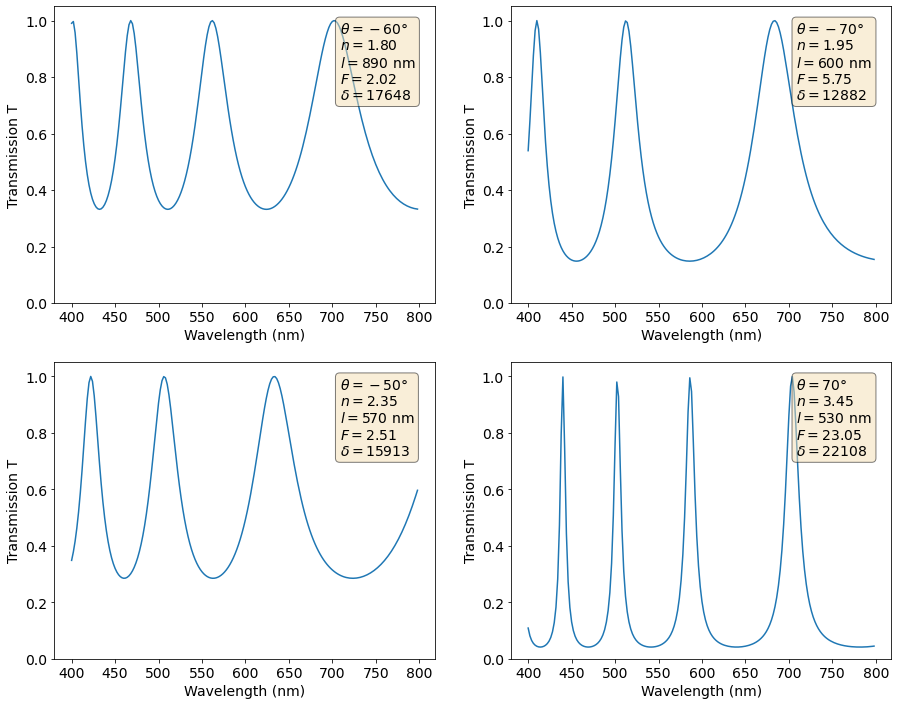

In [18]:
# Plot transmission spectra of Fabry-Pérot resonator

import matplotlib.pyplot as plt

def plot_spects(vects, spects, Fd):
  plt.figure(figsize = (15, 6*np.ceil(len(spects)/2)))

  for i, spect in enumerate(spects):
    ax = plt.subplot(np.ceil(len(spects)/2), 2, i + 1)
    param = vects[i]
    plt.plot(lamb_0, spect)
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Transmission T", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1.05)
  
    textstr = '\n'.join((
      r'$\theta=%.i$°' % (param[0]),
      r'$n=%.2f$' % (param[1]),
      r'$l=%.i$ nm' % (param[2]),
      r'$F=%.2f$' % (Fd[i][0]),
      r'$\delta=%.i$' % (Fd[i][1])
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
           verticalalignment='top', bbox = props)

np.random.seed(3) 
idx = np.random.choice(range(len(spect)), 4)
plot_spects(vector[idx], spect[idx], Fd[idx])

Illustration of the non-uniqueness problem. Different resonator parameters can lead to the same transmission. 

Computing training sample 0 of 2
Shape of spect_0 is (2, 200)


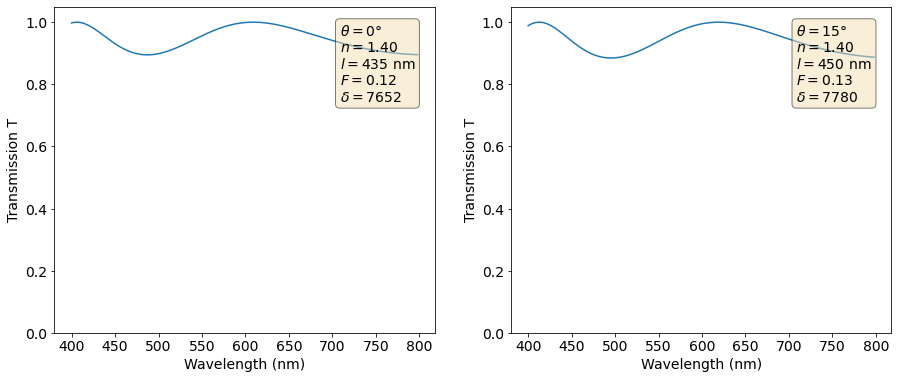

In [19]:
# Compute transmission for some chosen resonator parameters
vects = np.array([[0,1.4,435], [15, 1.4, 450]])
spects = make_spect(vects)
Fds = np.array([convert_Fd(vec) for vec in vects])

# Plot these transmissions
plot_spects(vects, spects, Fds) 

## Training 


### Test and training split


We split into a training set and a test set. The training set will be split up later in training and validation set when the network is training. 

In [20]:
import numpy as np

#Normalize resonator parameters to 0-1
def normalize(vector):
  norm = np.ones(vector.shape)
  for idx, triple in enumerate(vector):
    downtriple = triple - np.array([-90,1,100])
    downtriple = np.divide(downtriple, np.array([180,3,900])) 
    norm[idx] = downtriple
  return norm

def unnormalize(vector):
  unnorm = np.ones(vector.shape)
  for idx, triple in enumerate(vector):
    uptriple = np.multiply(triple, np.array([180,3,900])) 
    uptriple = uptriple + np.array([-90,1,100])
    unnorm[idx] = uptriple
  return unnorm

# Pick out test and training data
n_tot = len(vector)
n = int(0.9 * n_tot)
n_test = n_tot - n

print(f"We have {n_tot} samples: ")
print(f"First vector is {vector[0]} and last vector is {vector[-1]} \n")

index = np.arange(len(spect))
np.random.seed(0)
index = np.random.choice(index, n + n_test, replace = False)
x_train = vector[index[:n]]
x_test = vector[index[n:]]
x_train = normalize(x_train)
x_test = normalize(x_test)
print("We have {} training samples and {} test samples".format(len(x_train), len(x_test)))

Fd_train = Fd_norm[index[:n]]
Fd_test = Fd_norm[index[n:]]

y_train = spect[index[:n]]
y_test = spect[index[n:]]

We have 59150 samples: 
First vector is [-70.     1.05 100.  ] and last vector is [  70.     3.5 1000. ] 

We have 53235 training samples and 5915 test samples


### Training network

Putting training to True will train the neural network. We have done experiments with 4 to 6 hidden layers with either 100 or 200 nodes in each hidden layer. We also compared the Swish and ReLu activation functions. The results are shown in this notebook in the "experiments" section. 

This neural network will be trained to map the degrees of freedom $F$ and $\delta_0$ to the transmissions. 

In [21]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import time

# create swish activation function
def swish(x):
    return x*tf.keras.activations.sigmoid(x)
tf.keras.utils.get_custom_objects()['swish'] = tf.keras.layers.Activation(swish)

# Gives (4,2) array, first element is name (eg "loss"), second element is the list
def save_history(history, savename):
    array = np.array(list(history.history.items()))
    np.save(savename, array)

def init_csv(path_exp):
  df = pd.DataFrame(columns=["Run", "Set-up", "Activation", "Train MAE", "Val MAE",
                             "Training time", "Epochs", "Saved as"])
  df.to_csv(path + path_exp + "Training results.csv")

def add_row_to_csv(row, path_exp):
  df = pd.read_csv(path + path_exp + "Training results.csv", index_col=0)
  df = df.append(row, ignore_index=True)
  df.to_csv(path + path_exp + "Training results.csv")

def create_network(layers, nodes, activation):
  #kernel_initializer='glorot_uniform', other options: he_uniform of he_normal

  input_layer = [tf.keras.layers.Flatten(input_shape=(2,))]
  hidden_layers = [tf.keras.layers.Dense(nodes, activation=activation) for i in range(layers)]
  output_layer = [tf.keras.layers.Dense(200)]

  layers = input_layer + hidden_layers + output_layer

  model = tf.keras.models.Sequential(layers)

  model.compile(optimizer="adam",
                   loss='mse',
                   metrics = ['mae'])
  return model

def train_network(model, setup, run, savename, historyname, log_dir, path_exp, activation):
  start = time.time()

  # Callbacks
  %reload_ext tensorboard
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=0, patience = 30) 
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = savename, monitor='val_mae', 
                                                  verbose=0, save_best_only=True, mode='min')

  # Actual training
  history = model.fit(Fd_train, y_train, batch_size=200, epochs=500, validation_split=0.15,
                      callbacks = [tensorboard_callback, checkpoint], verbose=0)
  save_history(history, historyname)

  # Saving info in csv file
  n_epochs = len(history.history['mae'])
  best_index = np.argmin(history.history['val_mae'])
  train_mae = history.history['mae'][best_index]
  val_mae = history.history['val_mae'][best_index]
  # We can't compute the test mae here because this is the last model, not the best one
  diff = time.time() - start
  print(f"Training took {int(np.floor(diff / 60))} mins {int(diff % 60)} seconds")
  train_time = f"{int(np.floor(diff / 60))} mins {int(diff % 60)}s"
  
  row = pd.Series(index=["Run", "Set-up", "Activation", "Train MAE", "Val MAE", 
                         "Training time", "Epochs", "Saved as"],
                  data=[run, setup, activation, train_mae, val_mae, 
                        train_time, n_epochs, savename.replace(path, '')])
  add_row_to_csv(row, path_exp)
  return model

def train_run(number_runs=0):
  path_exp = "Networks Fabry-Pérot/"
  
  savename = path + path_exp + f"6layers100nodes_run{number_runs}_relu.hdf5"
  historyname = path + path_exp + f"history_6layers100nodes_run{number_runs}_relu.npy"
  logname = path + path_exp + f"logs/fit/6layers100nodes_run{number_runs}_relu"
  activation = 'relu'

  Fulcon = create_network(layers=6, nodes=100, activation=activation)
  Fulcon = train_network(Fulcon, setup=f"6 layers, 100 nodes", 
                         run=number_runs, 
                         savename=savename, 
                         historyname=historyname,
                         log_dir=logname,
                         path_exp=path_exp, 
                         activation=activation)
  
training = False

#init_csv(path_exp="Networks Fabry-Pérot/")
for i in range(1, 6):
  print(f"Busy on run {i}...")
  if training:
    train_run(i)

Busy on run 1...
Busy on run 2...
Busy on run 3...
Busy on run 4...
Busy on run 5...


## Analysis

### Random evaluation

In [31]:
# All networks trained
path_exp = "Networks Fabry-Pérot/"
df = pd.read_csv(path + path_exp + "Training results.csv", index_col=0)
#df["Saved as"] = df["Saved as"].str.replace("Original gangsters - hidden variables", "Networks Fabry-Pérot")
df#.to_csv(path + path_exp + "Training results.csv")

,Run,Set-up,Activation,Train MAE,Val MAE,Training time,Epochs,Saved as
0,1,"4 layers, 200 nodes",relu,0.011357,0.010968,10 mins 55s,784,Networks Fabry-Pérot/4layers200nodes_run1_relu...
1,2,"4 layers, 200 nodes",relu,0.013894,0.010871,10 mins 38s,744,Networks Fabry-Pérot/4layers200nodes_run2_relu...
2,3,"4 layers, 200 nodes",relu,0.011905,0.011439,10 mins 28s,771,Networks Fabry-Pérot/4layers200nodes_run3_relu...
3,4,"4 layers, 200 nodes",relu,0.015090,0.012259,7 mins 59s,587,Networks Fabry-Pérot/4layers200nodes_run4_relu...
4,5,"4 layers, 200 nodes",relu,0.014647,0.011999,5 mins 59s,438,Networks Fabry-Pérot/4layers200nodes_run5_relu...
5,1,"5 layers, 200 nodes",relu,0.010574,0.010079,7 mins 43s,524,Networks Fabry-Pérot/5layers200nodes_run1_relu...
6,2,"5 layers, 200 nodes",relu,0.010778,0.009386,7 mins 46s,530,Networks Fabry-Pérot/5layers200nodes_run2_relu...
7,3,"5 layers, 200 nodes",relu,0.010624,0.008883,9 mins 8s,631,Networks Fabry-Pérot/5layers200nodes_run3_relu...
8,4,"5 layers, 200 nodes",relu,0.010616,0.009493,6 mins 8s,435,Networks Fabry-Pérot/5layers200nodes_run4_relu...
9,5,"5 layers, 200 nodes",relu,0.011272,0.008704,9 mins 11s,647,Networks Fabry-Pérot/5layers200nodes_run5_relu...


In [35]:
# Best neural network
path_exp = "Networks Fabry-Pérot/"
total_res = pd.read_csv(path + path_exp + "Total results.csv", index_col=0)
best_res = total_res.loc[[total_res['Test MAE'].idxmin()]]
best_res

,Set-up,Train MAE,Val MAE,Test MAE,Training time,Epochs,Saved as,Activation
28,"6 layers, 200 nodes",0.004399,0.004148,0.004152,18 mins 25s,790,Networks Fabry-Pérot/6layers200nodes_run4_swis...,swish


[2575 5704 3606 2514]


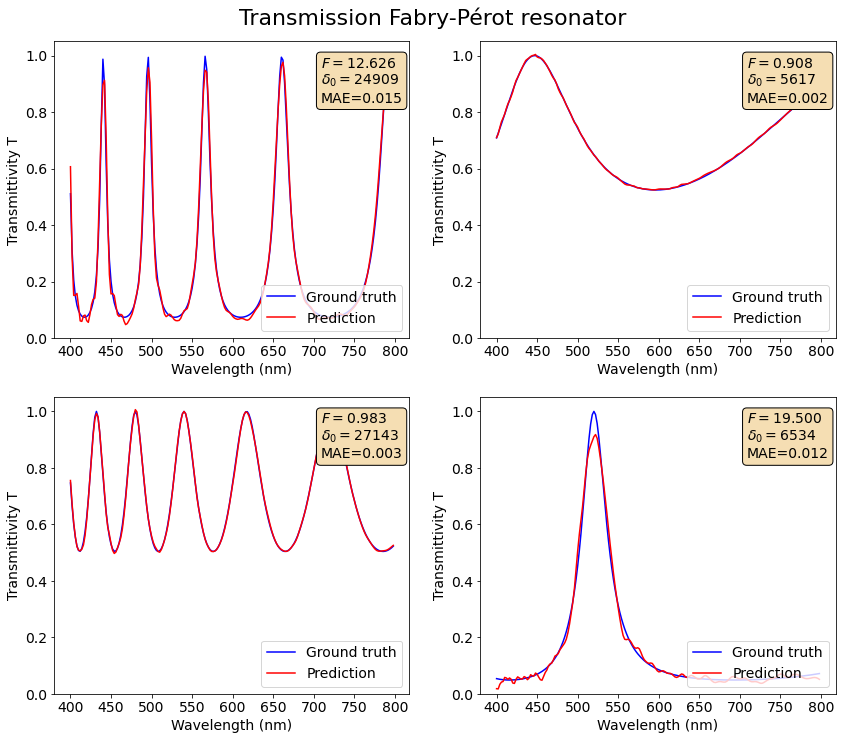

In [36]:
# Sample in this function is normalized
def predict(Fd_eval, y_eval, loadname, string="Predictions", swish_bool=False):
  if swish_bool:
    Fulcon = tf.keras.models.load_model(path + loadname,
                                          custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
  else:
    Fulcon = tf.keras.models.load_model(path + loadname)
  pred = Fulcon.predict(Fd_eval)
  unnorm = Fd_unnormalize(Fd_eval)

  plt.figure("Predictions", figsize = (14,12))
  plt.suptitle(string, fontsize = 22, y=0.92)
  for i in range(len(Fd_eval)):
    ax = plt.subplot(np.ceil(len(Fd_eval)/2),2,i+1)
    plt.plot(lamb_0, y_eval[i], 'b', label="Ground truth")
    plt.plot(lamb_0, pred[i], 'r', label="Prediction")
    plt.legend(loc = "lower right", fontsize=14)
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Transmittivity T", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1.05)

    err = tf.keras.losses.mean_absolute_error(y_eval[i], pred[i])
    textstr = '\n'.join((
      r'$F=%.3f$' % (unnorm[i][0]),
      r'$\delta_0=%.i$' % (unnorm[i][1]),
      r'MAE=%.3f' % (err)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox = props)
   
np.random.seed(2) #seed 2 toont slechte
eval_idx = np.random.choice(len(Fd_test), 4)
print(eval_idx)
Fd_eval = Fd_test[eval_idx]
y_eval = y_test[eval_idx]

best_model = best_res['Saved as'].values[0]
predict(Fd_eval, y_eval, 
        loadname = best_model, 
        string="Transmission Fabry-Pérot resonator", 
        swish_bool=True)

### Training history

The loss at the last epoch: 0.0001
The mae at the last epoch: 0.0052
The val_loss at the last epoch: 0.0001
The val_mae at the last epoch: 0.0048
metrics = [0.0001, 0.0069, 0.0001, 0.0068]




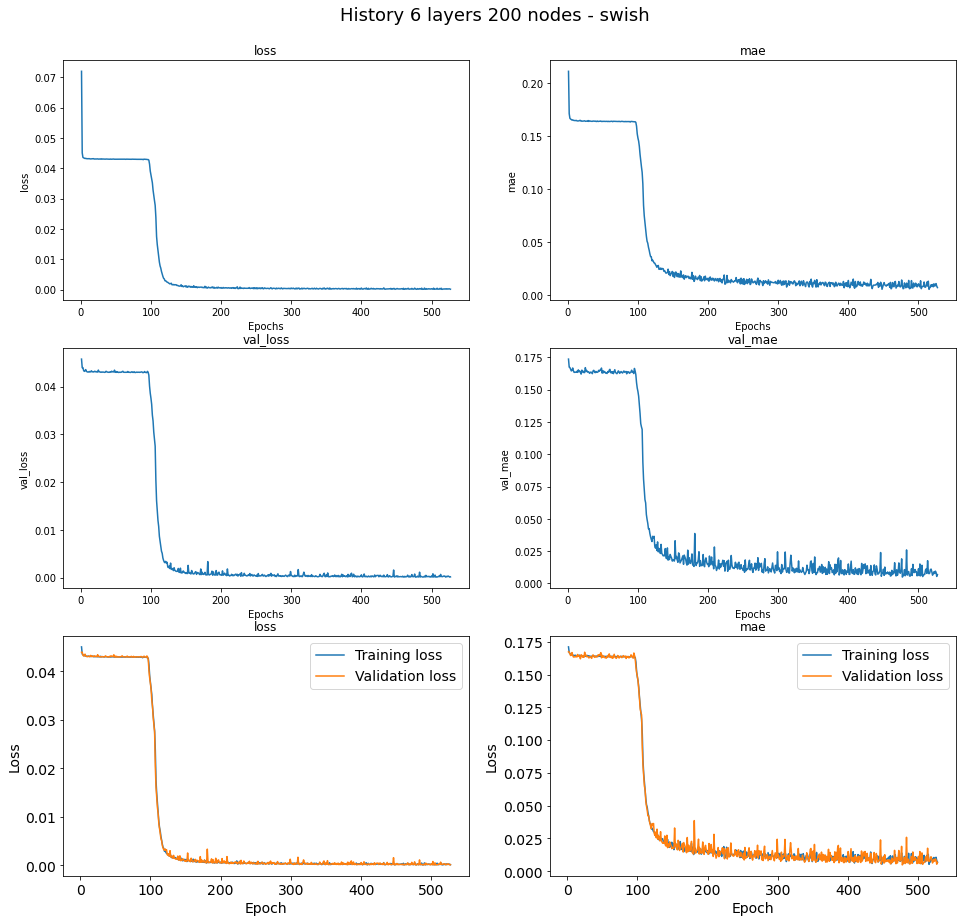

In [37]:
def plot_history(history, string="Training history"):
  plt.figure("Training history", figsize = (16, 15))
  plt.suptitle(string, fontsize=18, y=0.93)
  last_metrics =  []
  for i, row in enumerate(history):
      metric = row[0]
      n_epochs = len(row[1])
      plt.subplot(3,2, i+1)
      plt.plot(range(1, n_epochs + 1), row[1])
      plt.xlabel("Epochs")
      plt.ylabel(metric)
      plt.title(metric)
      print("The " + metric + f" at the last epoch: {min(row[1]):.4f}")
      last_metrics.append(np.round(row[1][-1],4))
  print(f"metrics = {last_metrics}")
  print("\n")
  for i in [0,1]:
      metric1 = history[i,0]
      metric2 = history[i+2,0]
      n_epochs = len(history[i,1])
      plt.subplot(3,2, i+5)
      plt.plot(range(2, n_epochs + 1), history[i,1][1:], label = "Training loss") #metric1
      plt.plot(range(2, n_epochs + 1), history[i+2,1][1:], label = "Validation loss") #metric2
      plt.legend(fontsize=14)
      plt.xlabel("Epoch", fontsize=14)
      plt.ylabel("Loss", fontsize=14)
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
      plt.title(metric1)
  plt.show()

def history_merge(history_list):
  for i, line in enumerate(history_list[0]):
    row = []
    for history in history_list:
      row.extend(history[i, 1])
    history_list[0][i, 1] = row
  return history_list[0]

path_exp = "Networks Fabry-Pérot/"
history = np.load(path + path_exp + f"history_6layers200nodes_run1_swish.npy", allow_pickle = True)
plot_history(history, string="History 6 layers 200 nodes - swish")

### Evaluate model

In [38]:
path_exp = "Networks Fabry-Pérot/"
Fulcon = tf.keras.models.load_model(path + best_res['Saved as'].values[0],
                                    custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
loss_train, mae_train = Fulcon.evaluate(Fd_train, y_train, verbose=False)
loss_test, mae_test = Fulcon.evaluate(Fd_test, y_test, verbose=False)

print(f"Final training loss is {loss_train:.05f}")
print(f"Final training mae is {mae_train:.05f}")
print(f"Final test loss is {loss_test:.05f}")
print(f"Final test mae is {mae_test:.05f}")

Final training loss is 0.00006
Final training mae is 0.00406
Final test loss is 0.00007
Final test mae is 0.00415


## Experiments

### Batch size experiment

Experiments on 4 layers, 100 nodes ReLU. 

In [40]:
path_exp = "Batch size experiment/"

total_res = pd.read_csv(path + path_exp + "Total results.csv", index_col=0)
total_res

,Batch size,Set-up,Activation,Train MAE,Val MAE,Test MAE,Training time,Epochs,Saved as
0,45250.0,"4 layers, 100 nodes",relu,0.148793,0.146286,0.146008,1 mins 47s,1000,Batch size experiment/batch45250.hdf5
1,200.0,"4 layers, 100 nodes",relu,0.033717,0.033161,0.033201,11 mins 6s,769,Batch size experiment/batch200.hdf5


Text(0, 0.5, 'MAE')

Text(0.5, 0, 'Batch size')

([<matplotlib.axis.XTick at 0x7f7505d4b390>,
 [Text(0, 0, '45250'), Text(0, 0, '200')])

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 <a list of 9 Text major ticklabel objects>)

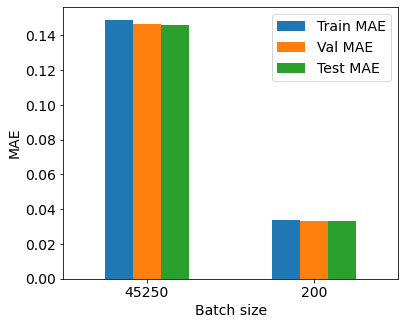

In [41]:
total_res.plot.bar(x='Batch size', y=['Train MAE', 'Val MAE', 'Test MAE'], figsize=(6, 5))

plt.ylabel("MAE", fontsize=14)
plt.xlabel("Batch size", fontsize=14)
plt.xticks([0, 1], [45250, 200], fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.show()

### Architecture

We compare different architectures of the neural network.

In [42]:
import pandas as pd

def add_activation_train():
  train_res = pd.read_csv(path + path_exp + "Training results.csv", index_col=0)
  train_res['Activation'] = train_res['Set-up'].apply(activation_from_setup)
  train_res = train_res.reindex(columns=["Set-up", "Train MAE", "Val MAE",  
                                         "Training time", "Epochs", "Saved as", "Activation"])
  train_res.to_csv(path + path_exp + "Training results.csv")

path_exp = "Networks Fabry-Pérot/"
train_res = pd.read_csv(path + path_exp + "Training results.csv", index_col=0)

In [43]:
# redefine swish activation function
def swish(x):
    return x*tf.keras.activations.sigmoid(x)
tf.keras.utils.get_custom_objects()['swish'] = tf.keras.layers.Activation(swish)

def file_to_testmae(savename):
  if 'swish' in savename:
    model = tf.keras.models.load_model(path + savename,
                                       custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
  else:
    model = tf.keras.models.load_model(path + savename)
  loss_test, mae_test = model.evaluate(Fd_test, y_test, verbose=False)
  return mae_test

def add_testmae():  
  total_res = train_res
  total_res['Test MAE'] = total_res['Saved as']
  total_res = total_res.reindex(columns=["Set-up", "Train MAE", "Val MAE", "Test MAE", 
                                         "Training time", "Epochs", "Saved as", "Activation"])
  total_res['Test MAE'] = total_res['Test MAE'].apply(file_to_testmae)
  total_res.to_csv(path + path_exp + "Total results.csv")

def activation_from_setup(string):
  if 'swish' in string:
    return 'swish'
  else:
    return 'relu'

def add_activation():
  total_res = pd.read_csv(path + path_exp + "Total results.csv", index_col=0)
  total_res['Activation'] = total_res['Set-up'].apply(activation_from_setup)
  total_res = total_res.reindex(columns=["Set-up", "Train MAE", "Val MAE", "Test MAE", 
                                         "Training time", "Epochs", "Saved as", "Activation"])
  total_res.to_csv(path + path_exp + "Total results.csv")

path_exp = "Networks Fabry-Pérot/"
total_res = pd.read_csv(path + path_exp + "Total results.csv", index_col=0)
total_res

,Set-up,Train MAE,Val MAE,Test MAE,Training time,Epochs,Saved as,Activation
0,"4 layers, 200 nodes",0.011357,0.010968,0.011045,10 mins 55s,784,Networks Fabry-Pérot/4layers200nodes_run1_relu...,relu
1,"4 layers, 200 nodes",0.013894,0.010871,0.010905,10 mins 38s,744,Networks Fabry-Pérot/4layers200nodes_run2_relu...,relu
2,"4 layers, 200 nodes",0.011905,0.011439,0.011462,10 mins 28s,771,Networks Fabry-Pérot/4layers200nodes_run3_relu...,relu
3,"4 layers, 200 nodes",0.015090,0.012259,0.012353,7 mins 59s,587,Networks Fabry-Pérot/4layers200nodes_run4_relu...,relu
4,"4 layers, 200 nodes",0.014647,0.011999,0.012058,5 mins 59s,438,Networks Fabry-Pérot/4layers200nodes_run5_relu...,relu
5,"5 layers, 200 nodes",0.010574,0.010079,0.010108,7 mins 43s,524,Networks Fabry-Pérot/5layers200nodes_run1_relu...,relu
6,"5 layers, 200 nodes",0.010778,0.009386,0.009403,7 mins 46s,530,Networks Fabry-Pérot/5layers200nodes_run2_relu...,relu
7,"5 layers, 200 nodes",0.010624,0.008883,0.008922,9 mins 8s,631,Networks Fabry-Pérot/5layers200nodes_run3_relu...,relu
8,"5 layers, 200 nodes",0.010616,0.009493,0.009521,6 mins 8s,435,Networks Fabry-Pérot/5layers200nodes_run4_relu...,relu
9,"5 layers, 200 nodes",0.011272,0.008704,0.008780,9 mins 11s,647,Networks Fabry-Pérot/5layers200nodes_run5_relu...,relu


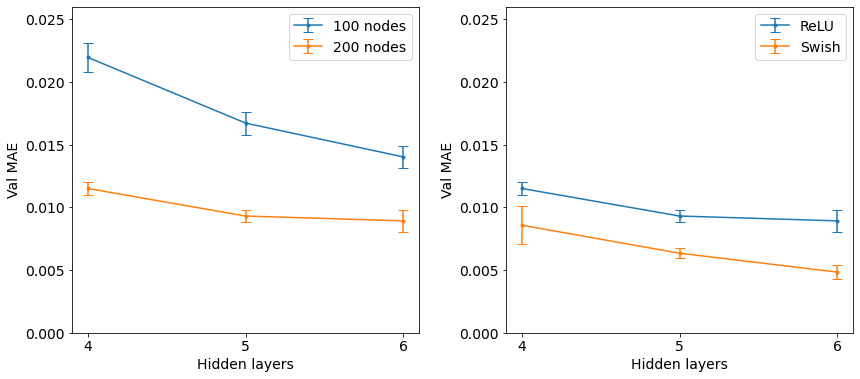

In [44]:
def mae(layers, nodes, activation='relu'):
  group = total_res[total_res['Activation']==activation]
  group = group[group['Set-up'].str.contains(f"{layers} layers, {nodes} nodes")]
  val_mae = group['Val MAE'].values
  test_mae = group['Test MAE'].values
  return {"Val" : val_mae, "Test" : test_mae}

path_exp = "Networks Fabry-Pérot/"
total_res = pd.read_csv(path + path_exp + "Total results.csv", index_col=0)

val_100 = [mae(layers, 100)['Val'].mean() for layers in [4, 5, 6]]
valerr_100 = [mae(layers, 100)['Val'].std() for layers in [4, 5, 6]]
val_200 = [mae(layers, 200)['Val'].mean() for layers in [4, 5, 6]]
valerr_200 = [mae(layers, 200)['Val'].std() for layers in [4, 5, 6]]

val_relu = [mae(layers, 200)['Val'].mean() for layers in [4, 5, 6]]
valerr_relu = [mae(layers, 200)['Val'].std() for layers in [4, 5, 6]]
val_swish = [mae(layers, 200, activation='swish')['Val'].mean() for layers in [4, 5, 6]]
valerr_swish = [mae(layers, 200, activation='swish')['Val'].std() for layers in [4, 5, 6]]

def custom_plot():
  plt.figure(figsize=(14, 6))

  # Comparing 100-200 nodes
  plt.subplot(1, 2, 1)
  plt.errorbar(x=[4, 5, 6],y=val_100, yerr=valerr_100, label="100 nodes", marker=".", capsize=5)
  plt.errorbar(x=[4, 5, 6],y=val_200, yerr=valerr_200, label="200 nodes", marker=".", capsize=5)
  plt.xlabel("Hidden layers", fontsize=14)
  plt.xticks(ticks=[4, 5, 6], label=[4, 5, 6], fontsize=14)
  plt.yticks(fontsize=14)
  plt.ylabel("Val MAE", fontsize=14)
  plt.ylim(0, 0.026)
  plt.legend(fontsize=14)

  # Comparing ReLU and swish activation
  plt.subplot(1, 2, 2)
  plt.errorbar(x=[4, 5, 6],y=val_relu, yerr=valerr_relu, label="ReLU", marker=".", capsize=5)
  plt.errorbar(x=[4, 5, 6],y=val_swish, yerr=valerr_swish, label="Swish", marker=".", capsize=5)
  plt.xlabel("Hidden layers", fontsize=14)
  plt.xticks(ticks=[4, 5, 6], label=[4, 5, 6], fontsize=14)
  plt.yticks(fontsize=14)
  plt.ylabel("Val MAE", fontsize=14)
  plt.ylim(0, 0.026)
  plt.legend(fontsize=14)

  plt.subplots_adjust(wspace=0.25)
  plt.show()

custom_plot()

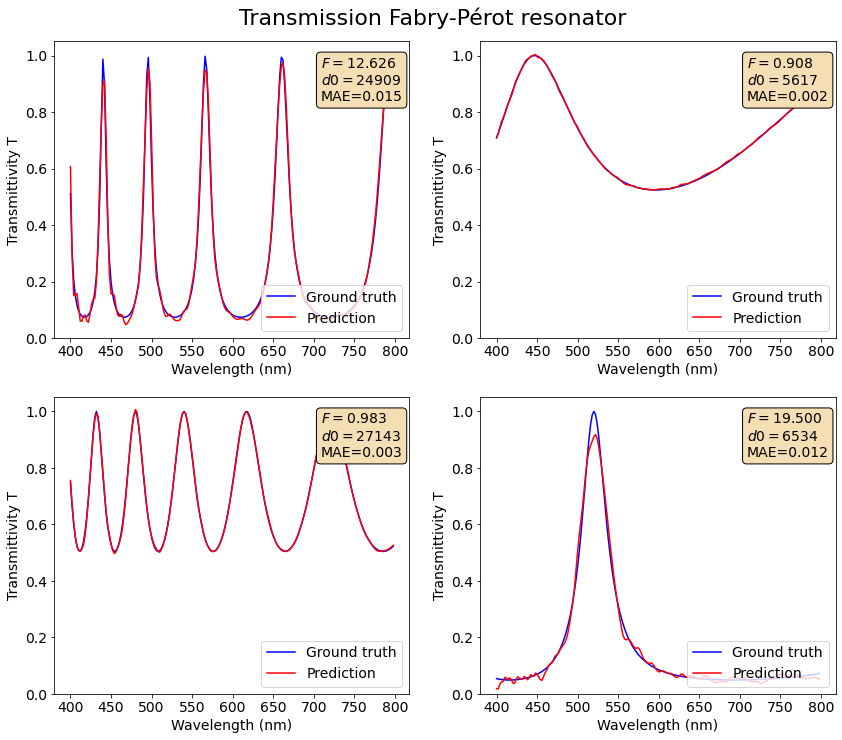

In [45]:
# Sample in this function is normalized
def predict(Fd_eval, y_eval, loadname, string="Predictions", swish_bool=False):
  if swish_bool:
    Fulcon = tf.keras.models.load_model(path + loadname,
                                          custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
  else:
    Fulcon = tf.keras.models.load_model(path + loadname)
  pred = Fulcon.predict(Fd_eval)
  Fd_eval_denorm = Fd_unnormalize(Fd_eval)

  plt.figure("Predictions", figsize = (14,12))
  plt.suptitle(string, fontsize = 22, y=0.92)
  for i in range(len(Fd_eval)):
    ax = plt.subplot(np.ceil(len(Fd_eval)/2),2,i+1)
    plt.plot(lamb_0, y_eval[i], 'b', label="Ground truth")
    plt.plot(lamb_0, pred[i], 'r', label="Prediction")
    plt.legend(loc = "lower right", fontsize=14)
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Transmittivity T", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1.05)

    err = tf.keras.losses.mean_absolute_error(y_eval[i], pred[i])
    textstr = '\n'.join((
      r'$F=%.3f$' % (Fd_eval_denorm[i][0]),
      r'$d0=%.i$' % (Fd_eval_denorm[i][1]),
      r'MAE=%.3f' % (err)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox = props)
   
np.random.seed(2)
eval_idx = np.random.choice(len(Fd_test), 4)
Fd_eval = Fd_test[eval_idx]
y_eval = y_test[eval_idx]

best_model = best_res['Saved as'].values[0]
predict(Fd_eval, y_eval, 
        loadname = best_model, 
        string="Transmission Fabry-Pérot resonator",
        swish_bool = True)

# Step 2: Inverse design on F and $\delta_0$

## Best model

In [46]:
# First, we pick out the best neural network that we trained in step 1

import pandas as pd

def file_to_testmae(savename):
  if 'swish' in savename:
    model = tf.keras.models.load_model(path + savename,
                                       custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
  else:
    model = tf.keras.models.load_model(path + savename)
  loss_test, mae_test = model.evaluate(Fd_test, y_test, verbose=False)
  return mae_test

def add_testmae():  
  total_res = train_res
  total_res['Test MAE'] = total_res['Saved as']
  total_res = total_res.reindex(columns=["Run", "Set-up", "Activation", "Train MAE", "Val MAE", "Test MAE", 
                                         "Training time", "Epochs", "Saved as"])
  total_res['Test MAE'] = total_res['Test MAE'].apply(file_to_testmae)
  total_res.to_csv(path + path_exp + "Total results.csv")

path_exp = "Networks Fabry-Pérot/"
train_res = pd.read_csv(path + path_exp + "Training results.csv", index_col=0)

In [47]:
tot_res = pd.read_csv(path + path_exp + "Total results.csv", index_col=0)

In [48]:
best_res = tot_res.loc[[tot_res['Test MAE'].idxmin()]]
best_model = best_res['Saved as'].values[0]
Fulcon = tf.keras.models.load_model(path + best_model,
                                      custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
best_res

,Set-up,Train MAE,Val MAE,Test MAE,Training time,Epochs,Saved as,Activation
28,"6 layers, 200 nodes",0.004399,0.004148,0.004152,18 mins 25s,790,Networks Fabry-Pérot/6layers200nodes_run4_swis...,swish


## Fourier transform of transmission $T(\lambda)$

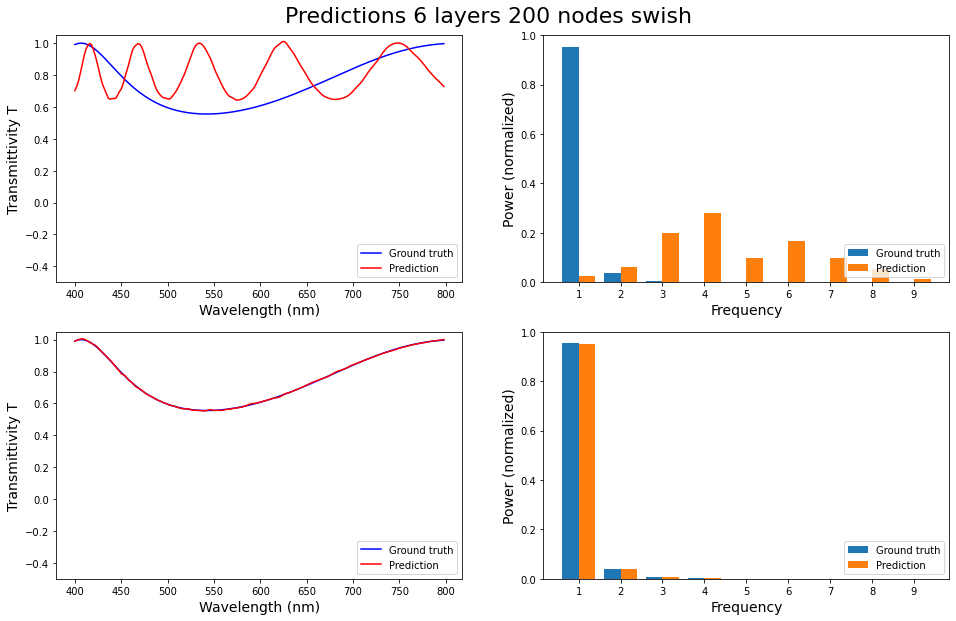

In [49]:
# Shows the a local and the global minimum for transmission 82 of the test set
# the transmissions and their fourier spectra are given 

def predict(Fd_eval, y_eval, model, string="Predictions", swish_bool=False):
  pred = model.predict(Fd_eval)
  Fd_eval_denorm = Fd_unnormalize(Fd_eval)

  plt.figure("Predictions", figsize = (16,10))
  plt.suptitle(string, fontsize = 22, y=0.92)
  for i in range(len(Fd_eval)):
    
    # Fourier
    ax = plt.subplot(np.ceil(len(Fd_eval)/2)*2,2,2*i + 2)
    cutoff = 10

    fourier = (np.abs(np.fft.fft(y_eval[i]))/200)**2
    fourier_angle = np.angle(np.fft.fft(y_eval[i][1:cutoff])/200)
    power = sum(2*fourier[1:cutoff])
    fourier = 2*fourier[1:cutoff] / power

    fourier_pred = (np.abs(np.fft.fft(pred[i]))/200)**2
    fourier_angle_pred = np.angle(np.fft.fft(pred[i][1:cutoff])/200)
    power_pred = sum(2*fourier_pred[1:cutoff])
    fourier_pred = 2*fourier_pred[1:cutoff] / power_pred

    width=0.40
    ax.bar(np.arange(1, len(fourier) + 1) - width/2, fourier, width, label="Ground truth")
    ax.bar(np.arange(1, len(fourier) + 1) + width/2, fourier_pred, width, label="Prediction")
    plt.legend(loc = "lower right")
    plt.xticks(np.arange(1, 10))
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Power (normalized)", fontsize=14)

    textstr = '\n'.join((
      r'$Power=%.3f$' % (power),
      r'$Pred power=%.3f$' % (power_pred)
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    """ax.text(0.70, 0.95, textstr, transform=ax.transAxes, fontsize=11,
          verticalalignment='top', bbox = props)"""
    
    # Signal
    ax = plt.subplot(np.ceil(len(Fd_eval)/2)*2,2,2*i+1)
    plt.plot(lamb_0, y_eval[i], 'b', label="Ground truth")
    plt.plot(lamb_0, pred[i], 'r', label="Prediction")
    plt.legend(loc = "lower right")
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Transmittivity T", fontsize=14)
    plt.ylim(-0.5, 1.05)

    err = tf.keras.losses.mean_absolute_error(y_eval[i], pred[i])
    textstr = '\n'.join((
      r'$F=%.3f$' % (Fd_eval[i][0]),
      r'$\delta_0=%.3f$' % (Fd_eval[i][1]),
      r'mae=%.3f' % (err)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    """ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=11,
          verticalalignment='top', bbox = props)"""
    
np.random.seed(0)
# Fd's are the result of earlier inverse design run on transmission 82
Fd_eval = np.array([[-0.95293, 0.08360], [-0.93226, -0.76438]])
y_eval = np.array([y_test[82], y_test[82]])

best_model = best_res['Saved as'].values[0]
Fulcon = tf.keras.models.load_model(path + best_model,
                                    custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
predict(Fd_eval, y_eval, 
        model = Fulcon, 
        string="Predictions 6 layers 200 nodes swish")

## Loss landscape

True F and d: (-0.932, -0.764)


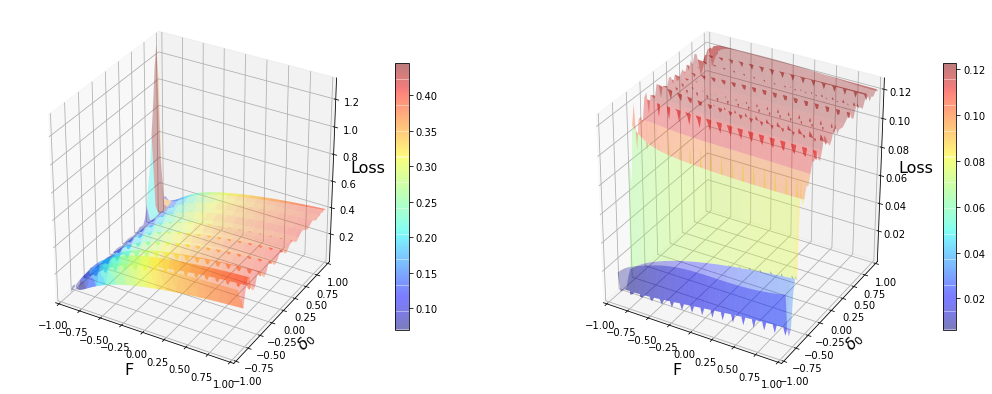

In [50]:
# Compute the 2 loss functions on original transmissions and their 
# Fourier spectrum side by side

from mpl_toolkits.mplot3d import axes3d
%tensorflow_version 2.x
import tensorflow as tf

def compute_loss(F, d0, y_true):
  x = tf.expand_dims(np.array([F, d0]), axis=0)
  x = tf.convert_to_tensor(x)
  y_pred = Fulcon(inputs=x)[0]

  complex_pred = tf.signal.fft(tf.cast(y_pred, dtype=tf.complex64))/200
  fourier_pred = (tf.abs(complex_pred))**2
  angle_pred = tf.math.angle(complex_pred)
  vector_pred = [[tf.math.real(complex_pred[i]).numpy(), tf.math.imag(complex_pred[i]).numpy()] for i in range(10)]

  complex_true = tf.signal.fft(tf.cast(y_true, dtype=tf.complex64))/200
  fourier_true = (tf.abs(complex_true))**2
  angle_true = tf.math.angle(complex_true)
  vector_true = [[tf.math.real(complex_true[i]), tf.math.imag(complex_true[i])] for i in range(10)]

  power_pred = tf.reduce_sum(2*fourier_pred[1:10])
  fourier_pred = 2*fourier_pred[1:10] / power_pred
  power_true = tf.reduce_sum(2*fourier_true[1:10])
  fourier_true = 2*fourier_true[1:10] / power_true

  power_loss = tf.keras.losses.mean_squared_error([power_true], [power_pred])
  fourier_loss = tf.keras.losses.mean_squared_error(fourier_true, fourier_pred)
  angle_loss = tf.keras.losses.mean_squared_error(angle_pred, angle_true)
  signal_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
  cos_loss_full = tf.keras.losses.cosine_similarity([np.array(vector_pred)], [np.array(vector_true)])
  cos_loss = tf.reduce_mean(cos_loss_full)

  loss = {'signal': signal_loss, 'fourier': fourier_loss, 
          'power': power_loss, 'angle': angle_loss, 'cos': cos_loss}
  return loss

def custom_plot(Fd_true, y_true):
  fig, axs = plt.subplots(figsize=(18, 7), nrows=1, ncols=2, 
                          subplot_kw={'projection': '3d'})
  
  sampling = 50
  F_3d = np.linspace(-0.95, 1, sampling)
  d0_3d = np.linspace(-0.90, 1, sampling)
  F_mesh, d0_mesh = np.meshgrid(F_3d, d0_3d)
  loss_fourier = np.array([compute_loss(F, d0, y_true)['fourier'] for d0 in d0_3d for F in F_3d]).reshape(sampling, sampling)
  loss_trans = np.array([compute_loss(F, d0, y_true)['signal'] for d0 in d0_3d for F in F_3d]).reshape(sampling, sampling)

  surf = axs[0].plot_surface(F_mesh, d0_mesh, loss_trans, rstride=3, cstride=3, alpha=0.3, cmap='jet')
  plt.colorbar(surf, shrink=0.7, ax=axs[0])

  axs[0].set_xlabel('F', fontsize=16)
  axs[0].set_xlim(-1, 1)
  axs[0].set_ylabel('$\delta_0$', rotation=0, fontsize=16)
  axs[0].set_ylim(-1, 1)
  axs[0].set_zlabel('Loss', fontsize=16)

  surf = axs[1].plot_surface(F_mesh, d0_mesh, loss_fourier, rstride=3, cstride=3, alpha=0.3, cmap='jet')
  plt.colorbar(surf, shrink=0.7, ax=axs[1])

  axs[1].set_xlabel('F', fontsize=16)
  axs[1].set_xlim(-1, 1)
  axs[1].set_ylabel('$\delta_0$', rotation=0, fontsize=16)
  axs[1].set_ylim(-1, 1)
  axs[1].set_zlabel('Loss', fontsize=16)

  plt.show()

Fd_true = Fd_test[82]
y_true = y_test[82]

print(f"True F and d: ({Fd_true[0]:.03f}, {Fd_true[1]:.03f})")
custom_plot(Fd_true=Fd_true, y_true=y_true)

True F and d: (-0.932, -0.764) 



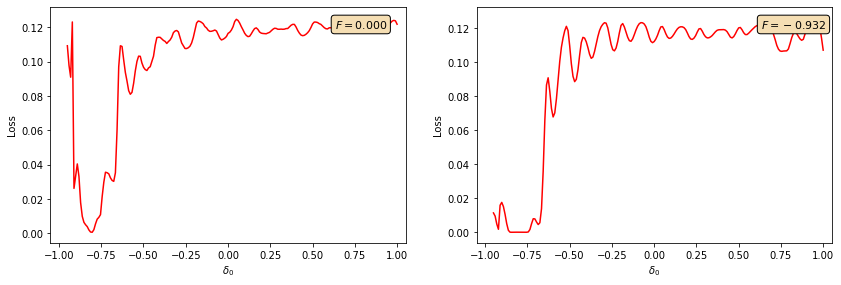

In [52]:
# Compute cross-sections in the delta direction with d_plot
# in the F direction with F_plot and in both with combi_plot

def d_plot(y_true, Fd_true):
  fig = plt.figure(figsize=(14, 10))

  F_values = [0.0, Fd_true[0]]
  d0_values = np.linspace(-0.95, 1, 200)
  titles = {0 : "Initial", 1 : "Epoch 200",
            2 : "Epoch 400", 3 : "Epoch 800"}
  losses = list()
  for i, F in enumerate(F_values):
    loss = [compute_loss(F, d0, y_true) for d0 in d0_values]
    signal_loss = [l['signal'] for l in loss]
    fourier_loss = [l['fourier'] for l in loss]

    losses.append(fourier_loss)

    ax = plt.subplot(2, 2, i + 1)
    #plt.plot(d0_values, signal_loss, label='MSE Transmission')
    plt.plot(d0_values, np.array(fourier_loss), 'r')
    #plt.plot(d0_values, signal_loss + np.array(fourier_loss), 'm', label='MSE Combined')

    """F_min = np.min(signal_loss + np.array(fourier_loss))
    F_min_idx = np.argmin(signal_loss + np.array(fourier_loss))
    plt.plot(d0_values[F_min_idx], F_min, 'rx')"""
    plt.ylabel("Loss")
    plt.xlabel("$\delta_0$")
    plt.xlim(-1.05, 1.05)
    #plt.ylim(-0.1, 0.65)
    #plt.legend(loc='lower right')
    #plt.title(titles[i])

    plt.subplots_adjust(hspace=0.3)

    textstr = '\n'.join((
      r'$F=%.3f$' % (F),
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=11,
          verticalalignment='top', bbox = props)

  plt.show()
  return np.array(losses)

def F_plot(y_true):
  fig = plt.figure(figsize=(18, 10))

  F_values = np.linspace(-1, 1, 200)
  d0_values = [-0.99, -0.9, -0.5, 0.0]

  for i, d0 in enumerate(d0_values):
    signal_loss = [compute_loss(F, d0, y_true)['signal'] for F in F_values]
    power_loss = [compute_loss(F, d0, y_true)['power'] for F in F_values]
    fourier_loss = [compute_loss(F, d0, y_true)['fourier'] for F in F_values]
    ax = plt.subplot(2, 2, i + 1)
    plt.plot(F_values, signal_loss, label='Signal')
    F_min = np.min(signal_loss)
    F_min_idx = np.argmin(signal_loss)
    plt.plot(F_values[F_min_idx], F_min, 'rx')
    plt.plot(F_values, 20*np.array(fourier_loss), 'r', label='Fourier')
    plt.plot(F_values, signal_loss + 20*np.array(fourier_loss), 'm', label='Combined')
    plt.ylabel("Loss")
    plt.xlabel("F")
    plt.xlim(-1.05, 1.05)
    plt.legend(loc='lower right')

    textstr = '\n'.join((
      r'$d0=%.3f$' % (d0),
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=11,
          verticalalignment='top', bbox = props)

  plt.show()

def combi_plot(y_true, Fd_true):
  fig = plt.figure(figsize=(16, 6))

  F_values = np.linspace(-1, 1, 200)
  d0_values = np.linspace(-1, 1, 200)

  ax = plt.subplot(1, 2, 1)
  signal_loss = [compute_loss(Fd_true[0], d0, y_true)['signal'] for d0 in d0_values]
  fourier_loss = [compute_loss(Fd_true[0], d0, y_true)['fourier'] for d0 in d0_values]
  plt.plot(d0_values, signal_loss)
  """F_min = np.min(signal_loss)
    F_min_idx = np.argmin(signal_loss)
    plt.plot(F_values[F_min_idx], F_min, 'rx')"""
  plt.ylabel("MSE loss", fontsize=14)
  plt.xlabel("$\delta_0$", fontsize=16)
  plt.xlim(-1.05, 1.05)
  plt.ylim(0, 0.35)
  
  textstr = '\n'.join((
    r'$F=%.3f$' % (Fd_true[0]),
  ))
  props = dict(boxstyle='round', facecolor='wheat', alpha=1)
  ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox = props)
  
  ax = plt.subplot(1, 2, 2)
  signal_loss = [compute_loss(F, Fd_true[1], y_true)['signal'] for F in F_values]
  #fourier_loss = [compute_loss(F, d0, y_true)['fourier'] for F in F_values]
  plt.plot(F_values, signal_loss)
  """F_min = np.min(signal_loss)
    F_min_idx = np.argmin(signal_loss)
    plt.plot(F_values[F_min_idx], F_min, 'rx')"""
  plt.ylabel("MSE loss", fontsize=14)
  plt.xlabel("F", fontsize=16)
  plt.xlim(-1.05, 1.05)
  plt.ylim(0, 0.35)
  
  textstr = '\n'.join((
    r'$\delta_0=%.3f$' % (Fd_true[1]),
  ))
  props = dict(boxstyle='round', facecolor='wheat', alpha=1)
  ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox = props)

  plt.show()

Fd_true = Fd_test[82]
y_true = y_test[82]

print(f"True F and d: ({Fd_true[0]:.03f}, {Fd_true[1]:.03f}) \n")
losses = d_plot(y_true=y_true, Fd_true=Fd_true)

## Gradient descent

In [53]:
import matplotlib.gridspec as gridspec
from matplotlib.cbook import get_sample_data
import matplotlib 
matplotlib.use('Agg')
from IPython import display
import matplotlib.pylab as pylab
import pandas as pd
import time

# Functions:
#   - plot_param: to create the plot
#   - make_gif: to combine all saved plots in a gif

def plot_param(param_list, Fd_true, y_true, step, big):
  
  fig = plt.figure(figsize=(15, 11))
  plt.suptitle(f'Inverse design step {step}', fontsize=22, y=0.94)
  gs = gridspec.GridSpec(2, 3)

  last_step = (step == (len(param_list['F']) - 1))
  current_param = [param_list['F'][step],
                   param_list['d0'][step], 
                   param_list['loss'][step]]
  if step == 0:
    current_param[2] = param_list['loss'][1]
  loss_true = param_list['loss'][0]
  
  # Predictions to plot spectrum
  x_in = tf.expand_dims(tf.convert_to_tensor(current_param[0:2]), axis=0)
  y_pred = Fulcon(inputs=x_in)[0]
  
  # Show Fourier
  ax = plt.subplot(gs[0, 0])

  fourier_true = (np.abs(np.fft.fft(y_true))/200)**2
  DC_true = fourier_true[0]
  power_true = sum(2*fourier_true[1:10])
  fourier_true = 2*fourier_true[1:10] / power_true

  fourier_pred = (np.abs(np.fft.fft(y_pred))/200)**2
  DC_pred = fourier_pred[0]
  power_pred = sum(2*fourier_pred[1:10])
  fourier_pred = 2*fourier_pred[1:10] / power_pred

  width = 0.35
  ax.bar(np.arange(1, 10) - width/2, fourier_true, width, label='Ground truth')
  ax.bar(np.arange(1, 10) + width/2, fourier_pred, width, label='Prediction')
  plt.legend(loc = 'upper right', fontsize=14)
  plt.ylim([0, 1])
  plt.xlabel("Frequencies", fontsize=16)
  plt.ylabel("Power (normalized)", fontsize=16)

  fourier_loss = tf.keras.losses.mean_absolute_error(fourier_true, fourier_pred)
  textstr = '\n'.join((
      f'$MAE=%.3f$' % (fourier_loss),
    ))
  props = dict(boxstyle='round', facecolor='wheat', alpha=1)

  # Big makes the image suited for the thesis
  
  if not big:
    ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox = props)

  # Plot F
  plt.subplot(gs[0, 1])
  F_list = param_list['F']
  plt.plot([Fd_true[0] for i in range(len(F_list))], '--', label='Ground truth')
  plt.plot([0] + F_list, 'C1', label='Prediction')
  plt.plot(step, current_param[0], 'ro')
  plt.xlabel('Iteration', fontsize=16)
  plt.ylabel('F', fontsize=18, rotation=0)
  plt.ylim([-1.05, 1.05]) 
  plt.legend(fontsize=14)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)

  # Plot d0
  plt.subplot(gs[0, 2])
  d0_list = param_list['d0']
  plt.plot([Fd_true[1] for i in range(len(d0_list))], '--', label='Ground truth')
  plt.plot([0] + d0_list, 'C1', label='Prediction')
  plt.plot(step, current_param[1], 'ro')
  plt.xlabel('Iteration', fontsize=16)
  plt.ylabel('$\delta_0$', fontsize=18, rotation=0)
  plt.ylim([-1.05, 1.05]) 
  plt.legend(fontsize=14)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)

  # Plot spectrum
  ax = plt.subplot(gs[1, 0:2])
  #img_path = path + "Inverse design hidden variables/petitprincecut.png"
  #img = plt.imread(get_sample_data(img_path))
  #ax.imshow(img, zorder=0, extent=[0, 840, 0, 420])
  #plt.axis('off')
  #plt.plot(2*(lamb_0 - 400) + 10, y_true*400, 'b', label="Ground truth", zorder=1)
  #plt.plot(2*(lamb_0 - 400) + 10, y_pred*400, 'r', label='Prediction', zorder=1)
  plt.plot(lamb_0, y_true, 'b', label='Ground truth')
  plt.plot(lamb_0, y_pred, 'r', label="Prediction")
  plt.legend(loc = "lower right", fontsize=14)
  plt.xlabel("Wavelength (nm)", fontsize=16)
  plt.ylabel("Transmittivity T", fontsize=16)
  #plt.xticks(ticks=[20 + 100*i for i in range(9)], labels=[400 + 50*i for i in range(9)], fontsize=14)
  #plt.yticks(ticks=[400*0.2*i for i in range(6)], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
  plt.ylim(0, 1.05)

  err = tf.keras.losses.mean_absolute_error(y_true, y_pred)
  textstr = '\n'.join((
    r'$F=%.3f$' % (current_param[0]),
    r'$d0=%.3f$' % (current_param[1]),
    r'mae=%.3f' % (err)))
  props = dict(boxstyle='round', facecolor='wheat', alpha=1)
  
  if not big:
    ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox = props)
  
  # Plot loss
  ax = plt.subplot(gs[1, 2])
  loss_list = param_list['loss']
  plt.plot([loss_true for i in range(len(loss_list))], '--', label='Ground truth')
  plt.plot([loss_list[1]] + loss_list[1:], 'C1', label='Prediction')
  plt.plot(step, current_param[2], 'ro')
  plt.xlabel('Iteration', fontsize=16)
  plt.ylabel('Loss (mse)', fontsize=16)
  #plt.xticks(range(0, len(loss_list) + 1, 10))
  #plt.ylim([loss_true/10, max(loss_list) * 1.1]) 
  plt.yscale('log')
  plt.legend(fontsize=14)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)

  plt.subplots_adjust(wspace=0.35)
  plt.savefig(path + path_exp + f"temp/step {step}.png")
  if last_step:
    plt.show()
  else:
    plt.close(fig)

def make_gif(path_exp, mult_param, skip, multiple_inits, y_true, Fd_true, big):

  param_len = len(mult_param[0]['loss']) # param_len = epochs + 1

  # Make a plot for every param in param_list, including initial parameters
  for step in range(param_len): 
    if step % skip == 0:
      print(f"Plotting step {step}...")
      if multiple_inits:
        plot_mult_param(mult_param, Fd_true, y_true, step)
      else:
        param_list = mult_param[0]
        plot_param(param_list, Fd_true, y_true, step, big)

  # Turn plots into gif
  import imageio
  anim_file = path + path_exp + "Inverse design.gif"
  
  with imageio.get_writer(anim_file, mode='I') as writer:
    for i in range(param_len):
      if i % skip == 0:
        filename = path + path_exp + "temp/" + f"step {i}.png"
        image = imageio.imread(filename)
        writer.append_data(image)

In [54]:
# Functions:
#   - mse_loss: the loss function that we are minimizing with gradient descent
#   - compute_params: the actual gradient descent, gives the evolution of 
#                     F, d and loss during training as output in param_list

def mse_loss(x, y_true):
  # We use only signal loss, not fourier
  x = tf.expand_dims(x, axis=0)
  y_pred = Fulcon(inputs=x)[0]

  """fourier_true = tf.abs(tf.signal.fft(tf.cast(y_true, tf.complex64)))/200
  DC_true = fourier_true[0]
  power_true = tf.reduce_sum(2*fourier_true[1:10])
  fourier_true = 2*fourier_true[1:10] / power_true

  fourier_pred = tf.abs(tf.signal.fft(tf.cast(y_pred, tf.complex64)))/200
  DC_pred = fourier_pred[0]
  power_pred = tf.reduce_sum(2*fourier_pred[1:10])
  fourier_pred = 2*fourier_pred[1:10] / power_pred

  fourier_loss = tf.keras.losses.mean_squared_error(fourier_true, fourier_pred)"""
  signal_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)

  loss = signal_loss 
  return loss

# CHANGE OPTIMIZATION METHOD HERE 
def compute_params(init_list, y_true, epochs, verbose=True, re_initialize=True):
  param_list = init_list

  optimizer = tf.keras.optimizers.Adam(lr=0.001)

  # Initialize tensors
  F_step = tf.Variable(init_list['F'][0])
  d0_step = tf.Variable(init_list['d0'][0])

  loss = tf.constant(0.0)
  new_param = np.array([init_list['F'][0],
                        init_list['d0'][0]])
  if verbose:
    print(f"Initial d guess: {d0_step.numpy():.05f}, for F = 0.0")

  # Start gradient descent iterations
  for i in range(epochs):
    old_param = new_param

    # re-initialize every 100 epochs if re-initialize = true
    if i % 100 == 0 and i != 0 and re_initialize and loss > 10**(-3):
      d0_step.assign(d_guess(F_step.numpy(), y_true, kind='power'))
      if verbose:
        print(f"Epoch {i} d guess: {d0_step.numpy():.05f}, for F = {F_step.numpy():.05f}")

    # Calculate gradients
    with tf.GradientTape() as tape:
      loss = mse_loss(tf.convert_to_tensor([F_step, d0_step]), 
                      tf.convert_to_tensor(y_true))
      grad = tape.gradient(loss, [F_step, d0_step])
    grad_arr = np.array([grad[i].numpy() for i in range(2)])

    optimizer.apply_gradients(zip(tf.convert_to_tensor(grad), [F_step, d0_step]))    
    new_param = [F_step.numpy(), d0_step.numpy()]
    
    param_list['F'].append(new_param[0])
    param_list['d0'].append(new_param[1])
    param_list['loss'].append(loss.numpy())

  return param_list

Inverse design of transmission 0 (test set)
Initial d guess: -0.83838, for F = 0.0
Epoch 100 d guess: -0.83838, for F = -0.10159
Epoch 200 d guess: -0.83838, for F = -0.20781
Epoch 300 d guess: -0.83838, for F = -0.31947
Epoch 400 d guess: -0.83838, for F = -0.43759
Epoch 500 d guess: -0.83838, for F = -0.56288
Epoch 600 d guess: -0.83838, for F = -0.69344
Epoch 700 d guess: -0.83838, for F = -0.81529
True parameters: [-0.88673 -0.83637]
Initial d guess: -0.83838, for F = 0.00000
Final guess: [-0.8869457, -0.8364947]
MAE spectrum true: 0.00183, MAE spectrum guess: 0.00158
Plotting step 0...
Plotting step 50...
Plotting step 100...
Plotting step 150...
Plotting step 200...
Plotting step 250...
Plotting step 300...
Plotting step 350...
Plotting step 400...
Plotting step 450...
Plotting step 500...
Plotting step 550...
Plotting step 600...
Plotting step 650...
Plotting step 700...
Plotting step 750...
Plotting step 800...
Plotting step 850...
Plotting step 900...
Plotting step 950...
Plot

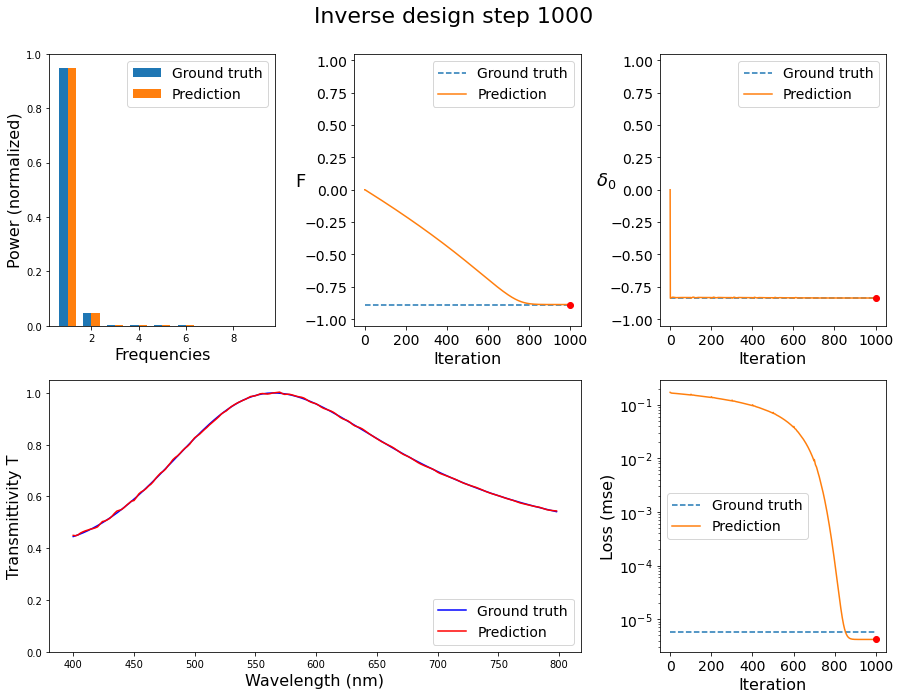

In [56]:
from google.colab import output

# Functions:
#   - d_guess: finds the optimal d for a given value of F, 
#              minimizing the signal_loss, fourier_loss of a combination
#   - init_csv_design: initializes pd DataFrame to save results of inverse design
#   - add_row_to_csv: adds a row to the pd DataFrame each time we perform an inverse design
#   - inverse_design: performs inverse design on transmission i from the test set
#                     if gif=True, it makes a gif of the training process
#                     otherwise it saves the training into a pd DataFrame

# kind = 'power'; I also performed experiments with kind = 'phase' loss function
# only the 'power' spectrum of Fourier loss function was useful though
def d_guess(F_guess, y_true, kind):
  best_loss = 20
  best_d = 0.0
  d_tries = np.linspace(-1, 1, 100)

  # Calculate Fourier space of y_true
  complex_true = tf.signal.fft(tf.cast(y_true, dtype=tf.complex64))/200
  fourier_true = (tf.abs(complex_true))**2
  power_true = tf.reduce_sum(2*fourier_true[1:10])
  fourier_true = 2*fourier_true[1:10] / power_true
  vector_true = [[tf.math.real(complex_true[i]).numpy(), tf.math.imag(complex_true[i]).numpy()] for i in range(10)]

  # Loop over possible values of delta (d)
  for d in d_tries:
    x = tf.expand_dims(np.array([F_guess, d]), axis=0)
    x = tf.convert_to_tensor(x)
    y_pred = Fulcon(inputs=x)[0]

    # Calculate Fourier space of y_true
    complex_pred = tf.signal.fft(tf.cast(y_pred, dtype=tf.complex64))/200
    fourier_pred = (tf.abs(complex_pred))**2
    power_pred = tf.reduce_sum(2*fourier_pred[1:10])
    fourier_pred = 2*fourier_pred[1:10] / power_pred
    vector_pred = [[tf.math.real(complex_pred[i]).numpy(), tf.math.imag(complex_pred[i]).numpy()] for i in range(10)]
  
    # Calculate loss for this value of d
    power_loss = tf.keras.losses.mean_squared_error([power_true], [power_pred])
    fourier_loss = tf.keras.losses.mean_squared_error(fourier_true, fourier_pred)
    signal_loss = tf.keras.losses.mean_squared_error(y_pred, y_true).numpy()
    cos_loss_full = tf.keras.losses.cosine_similarity([np.array(vector_pred)], [np.array(vector_true)])
    cos_loss = tf.reduce_mean(cos_loss_full)

    if kind=='power':
      loss = fourier_loss + signal_loss
    elif kind=='phase':
      loss = cos_loss

    # Change lowest loss so far
    if loss < best_loss:
      best_loss = loss
      best_d = d

  return best_d

def init_csv_design(savename):
  df = pd.DataFrame(columns=["Number", "F true", "F guess", "d true", "d guess",
                             "MAE ground truth", "MAE spectrum"])
  df.to_csv(path + savename)

def add_row_to_csv(row, savename):
  df = pd.read_csv(path + savename, index_col=0)
  df = df.append(row, ignore_index=True)
  df.to_csv(path + savename)

def inverse_design(i, gif, verbose, big):
  Fd_true = Fd_test[i]
  y_true = y_test[i]
  #y_true = np.array([1. for i in range(25)] + [0.5 for i in range(25)] + [1. for i in range(25)] +
  #                  [0.5 for i in range(50)] + [1.0 for i in range(50)] + [0.5 for i in range(25)]) BLOCK PULSE
  """y_true = np.array([0.55, 0.551, 0.554, 0.557, 0.561, 0.565, 0.568, 0.569, 0.570, 0.571, 0.572, 0.573] + 
                    [0.573, 0.573, 0.573, 0.572, 0.572, 0.572, 0.572, 0.572, 0.572, 0.571, 0.571, 0.571, 0.572, 0.573, 0.575] + 
                    [0.577, 0.581, 0.585, 0.589, 0.594] + [0.60, 0.607, 0.612, 0.62, 0.63, 0.67, 0.72, 0.77, 0.81, 0.84, 0.87, 0.89, 0.902] + 
                    [0.905, 0.913, 0.921, 0.929, 0.935, 0.940, 0.945, 0.949, 0.953, 0.956, 0.959, 0.961, 0.963, 0.965, 0.966] +
                    [0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966] +
                    [0.966, 0.965, 0.963, 0.961, 0.959, 0.957, 0.955, 0.953, 0.951, 0.950] +
                    [0.950, 0.947, 0.943, 0.940, 0.936, 0.931, 0.925, 0.920, 0.915, 0.910] +
                    [0.905, 0.900, 0.895, 0.890, 0.886, 0.883, 0.880, 0.876, 0.873, 0.87] +
                    [0.868 for i in range(15)] + [0.867, 0.866, 0.864, 0.862, 0.860, 0.858, 0.856, 0.854, 0.852, 0.847] +
                    [0.846, 0.83, 0.81, 0.79, 0.77, 0.75, 0.73, 0.71, 0.69, 0.67, 0.65, 0.63, 0.62] +
                    [0.61, 0.60, 0.594, 0.592, 0.589, 0.587, 0.584, 0.580, 0.578, 0.576, 0.574, 0.572, 0.570] +
                    [0.570 for i in range(35)] +
                    [0.570, 0.572, 0.575, 0.579, 0.583] + 
                    [0.587, 0.590, 0.594, 0.597, 0.601, 0.603, 0.604, 0.602, 0.60])  # ELEPHANT"""
  y_pred_true = Fulcon(np.array([Fd_true]))[0]
  signal_loss_true = tf.keras.losses.mean_squared_error(y_true, y_pred_true)

  # Initialize F and d0
  F_guess = 0.0
  d_init = d_guess(F_guess, y_true, kind='power')
  #d_init = -0.70
  init_param = {'F' : [0.0], 'd0' : [float(d_init)], 'loss' : [signal_loss_true.numpy()]} 

  # Start gradient descent
  param_list = compute_params(init_param, y_true, epochs=1000, 
                              verbose=verbose, re_initialize=True)

  # Calculate MAE between predicted and true transmission signal_mae_guess
  # compare this to signal_mae_true, which is the MAE due to the inaccuracy of the neural network
  Fd_guess = [param_list['F'][-1], param_list['d0'][-1]]
  mae_guess = tf.keras.losses.mean_absolute_error(Fd_true, Fd_guess)
  y_pred_guess = Fulcon(np.array([Fd_guess]))[0]
  signal_mae_guess = tf.keras.losses.mean_absolute_error(y_true, y_pred_guess)
  signal_mae_true = tf.keras.losses.mean_absolute_error(y_true, y_pred_true)

  if verbose:
    np.set_printoptions(precision=5)
    print(f"True parameters: {Fd_true}")
    print(f"Initial d guess: {d_init:.05f}, for F = {F_guess:.05f}")
    print(f"Final guess: {Fd_guess}")
    print(f"MAE spectrum true: {signal_mae_true:.05f}, MAE spectrum guess: {signal_mae_guess:.05f}")

  if gif:
    make_gif(path_exp=path_exp, mult_param=[param_list], skip=50, multiple_inits=False, 
             y_true=y_true, Fd_true=Fd_true, big=big)
  else:
    row = pd.Series(index=["Number", "F true", "F guess", "d true", "d guess", 
                          "MAE ground truth", "MAE spectrum"],
                    data= [i, Fd_true[0], Fd_guess[0], Fd_true[1], Fd_guess[1],
                            signal_mae_true.numpy(), signal_mae_guess.numpy()])
    add_row_to_csv(row, savename)

  return param_list

path_exp = "Nanophotonics paper/"
savename = path_exp + "Inverse design - fourier.csv"
#init_csv_design(savename)

start = time.time()
for i in [0]:
  print(f"Inverse design of transmission {i} (test set)")
  param_list = inverse_design(i, gif=True, verbose=True, big=True)
  if i % 10 == 0:
    diff = time.time() - start  
    print(f"I have been running for {int(np.floor(diff / 60))} mins {int(diff % 60)} seconds")
  fft_states_costs = np.array([[0, 0, 0.15]] + [[f, d, l] for f, d, l in zip(param_list['F'], param_list['d0'], param_list['loss'])])

True parameters: [-0.88673 -0.83637]
Final guess: [-0.8869457, -0.8364947]
MAE true: 0.00183, MAE guess: 0.00158, MAE analytic: 0.00106, 


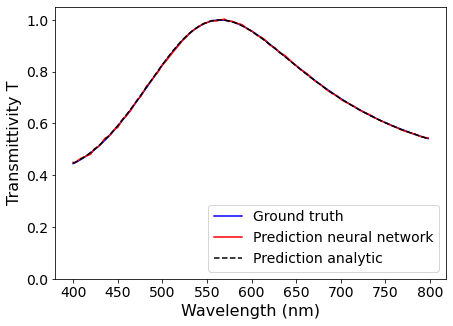

In [57]:
def inverse_design_figure(i, verbose):
  Fd_true = Fd_test[i]
  y_true = y_test[i]
  y_pred_true = Fulcon(np.array([Fd_true]))[0]
  signal_loss_true = tf.keras.losses.mean_squared_error(y_true, y_pred_true)

  # Initialize F and d0
  F_guess = 0.0
  d_init = d_guess(F_guess, y_true, kind='power')
  init_param = {'F' : [0.0], 'd0' : [float(d_init)], 'loss' : [signal_loss_true.numpy()]} 

  # Start gradient descent
  param_list = compute_params(init_param, y_true, epochs=1000, 
                              verbose=False, re_initialize=True)

  # Calculate MAE between predicted and true transmission signal_mae_guess
  Fd_guess = [param_list['F'][-1], param_list['d0'][-1]]
  mae_guess = tf.keras.losses.mean_absolute_error(Fd_true, Fd_guess)
  y_pred_guess = Fulcon(np.array([Fd_guess]))[0]
  Fd_unnorm = Fd_unnormalize(np.array(Fd_guess))
  y_pred_analytic = (1 + Fd_unnorm[0]*np.sin(Fd_unnorm[1]/(2*lamb_0))**2)**(-1)
  signal_mae_guess = tf.keras.losses.mean_absolute_error(y_true, y_pred_guess)
  signal_mae_analytic = tf.keras.losses.mean_absolute_error(y_true, y_pred_analytic)
  signal_mae_true = tf.keras.losses.mean_absolute_error(y_true, y_pred_true)

  if verbose:
    np.set_printoptions(precision=5)
    print(f"True parameters: {Fd_true}")
    print(f"Final guess: {Fd_guess}")
    print(f"MAE true: {signal_mae_true:.05f}, MAE guess: {signal_mae_guess:.05f}, MAE analytic: {signal_mae_analytic:.05f}, ")

  # Plot spectrum
  plt.figure(figsize=(7, 5))
  plt.plot(lamb_0, y_true, 'b', label='Ground truth')
  plt.plot(lamb_0, y_pred_guess, 'r', label='Prediction neural network')
  plt.plot(lamb_0, y_pred_analytic, 'k--', label='Prediction analytic')
  plt.legend(loc = "lower right", fontsize=14)
  plt.xlabel("Wavelength (nm)", fontsize=16)
  plt.ylabel("Transmittivity T", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.ylim(0, 1.05)
  plt.show()

inverse_design_figure(0, verbose=True)

## Simulated annealing

Implementation as in:

https://perso.crans.org/besson/publis/notebooks/Simulated_annealing_in_Python.html

In [58]:
# basic annealing vindt het globaal minimimum niet met maxsteps 15000 of minder
# random_neighbour verbeteren? 

def annealing(cost_function, random_neighbour, acceptance_probability, 
              temperature, maxsteps=1000, debug=True):
    """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
    state = [0.0, 0.0]
    cost = cost_function(state)
    states, costs = [state], [cost]

    for step in range(maxsteps):
        fraction = step / float(maxsteps)
        T = temperature(fraction)
        new_state = random_neighbour(state, 1 - fraction)
        new_cost = cost_function(new_state)
        if debug and (step + 1) % 100 == 0: 
          np.set_printoptions(precision=3)
          print(f"Step {step+1}/{maxsteps} : T = {T:.02f}, state = {state}, cost = {cost:.05f}")
        if acceptance_probability(cost, new_cost, T) > np.random.random():
            state, cost = new_state, new_cost
            states.append(state)
            costs.append(cost)
    return state, cost_function(state), states, costs

In [59]:
def clip(x):
    """ Force x to be in the interval."""
    a, b = -1., 1.
    return np.array([max(min(x[0], b), a), max(min(x[1], b), a)])

def random_neighbour(x, fraction=1):
    """ Stochastically roposes new states"""
    interval_length = 2
    amplitude = (interval_length) * fraction / 10
    delta = np.array([amplitude * (np.random.random_sample() - 1./2.),
                      amplitude * (np.random.random_sample() - 1./2.)])
    return clip(x + delta)

def acceptance_probability(cost, new_cost, temperature):
    """ Probability for the new state to be excepted"""
    if new_cost < cost:
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        return p

def temperature(fraction):
    """ Example of temperature dicreasing as the process goes on."""
    return max(0.01, min(1, 1 - fraction))

In [60]:
def cost_function(x):
  "The MSE loss on the transmissions"
  x = tf.expand_dims(x, axis=0)
  y_pred = Fulcon(inputs=x)[0]

  signal_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)

  loss = signal_loss 
  return loss.numpy()

def cost_function_analytic(x):
  "The MSE loss on the transmissions"
  lamb = np.arange(400, 800, 2).astype('float32')
  Fd = Fd_unnormalize(np.array(x))
  F = Fd[0]
  delta_0 = Fd[1]
  y_pred = (1 + F*np.sin(delta_0/(2*lamb))**2)**(-1)

  signal_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)

  loss = signal_loss 
  return loss.numpy()

Fd_true = Fd_test[0]
y_true = y_test[0]

state, cost, states, costs = annealing(cost_function=cost_function, random_neighbour=random_neighbour, 
                                       acceptance_probability=acceptance_probability, 
                                       temperature=temperature, maxsteps=1000, debug=True);

print(f"\nSimulated annealing: {state}")
print(f"True parameters: {Fd_true}")
print(f"\nMAE = {np.sqrt(cost)}\n")

Step 100/1000 : T = 0.90, state = [-0.132 -0.38 ], cost = 0.29840
Step 200/1000 : T = 0.80, state = [-0.958  0.37 ], cost = 0.04975
Step 300/1000 : T = 0.70, state = [-0.71  -0.331], cost = 0.17228
Step 400/1000 : T = 0.60, state = [-0.768 -0.373], cost = 0.14361
Step 500/1000 : T = 0.50, state = [-0.067 -0.531], cost = 0.31568
Step 600/1000 : T = 0.40, state = [-0.283 -0.032], cost = 0.28717
Step 700/1000 : T = 0.30, state = [ 0.024 -0.417], cost = 0.32376
Step 800/1000 : T = 0.20, state = [ 0.038 -0.346], cost = 0.31499
Step 900/1000 : T = 0.10, state = [ 0.141 -0.417], cost = 0.33594
Step 1000/1000 : T = 0.01, state = [ 0.104 -0.372], cost = 0.32183

Simulated annealing: [ 0.104 -0.372]
True parameters: [-0.887 -0.836]

MAE = 0.5672966241836548



'state, cost, states, costs = annealing(cost_function=cost_function_analytic, random_neighbour=random_neighbour, \n                                       acceptance_probability=acceptance_probability, \n                                       temperature=temperature, maxsteps=1000, debug=True);\n\nprint(f"\nSimulated annealing: {state}")\nprint(f"True parameters: {Fd_true}")\nprint(f"\nMAE = {np.sqrt(cost)}")'

In [62]:
# Dual annealing works very well
import sys
sys.path.append(path)

from home_made_optimize import home_made_dual_annealing
from scipy.optimize import dual_annealing

dual_states_costs_list = list()
def callback(x, f):
  dual_states_costs_list.append([x[0], x[1], f])
  print(f"Current state {x}")

Fd_true = Fd_test[0]
y_true = y_test[0]

ret = home_made_dual_annealing(cost_function_analytic, bounds=[(-1., 1.), (-1., 1.)], 
                               seed=0, maxiter=1000, callback=callback)
dual_states_costs = np.array(dual_states_costs_list)
np.save(path + "Inverse design Fabry-Pérot/dual_annealing_path.npy", dual_states_costs)

print(f"Simulated annealing: {ret.x}")
print(f"True parameters: {Fd_true}")
print(f"\nMAE = {np.sqrt(ret.fun)}")
print(ret.message)

Current state [-0.776 -0.443]
Current state [-0.605 -0.334]
Current state [ 0.219 -0.334]
Current state [0.219 0.037]
Current state [-0.953 -0.443]
Current state [-0.163 -0.444]
Current state [ 0.109 -0.172]
Current state [ 0.729 -0.172]
Current state [0.729 0.79 ]
Current state [0.923 0.19 ]
Current state [-0.277  0.99 ]
Current state [-0.445  0.99 ]
Current state [-0.445  0.57 ]
Current state [0.329 0.509]
Current state [0.695 0.875]
Current state [-0.652  0.875]
Current state [-0.652 -0.153]
Current state [0.053 0.553]
Current state [-0.459  0.041]
Current state [0.639 0.041]
Current state [0.639 0.889]
Current state [0.414 0.974]
Current state [0.607 0.138]
Current state [0.326 0.138]
Current state [ 0.326 -0.36 ]
Current state [0.992 0.616]
Current state [ 0.638 -0.38 ]
Current state [ 0.992 -0.38 ]
Current state [0.992 0.277]
Current state [-0.881  0.405]
Current state [0.948 0.673]
Current state [0.328 0.673]
Current state [0.328 0.779]
Current state [ 0.465 -0.115]
Current stat

## Plot optimization paths

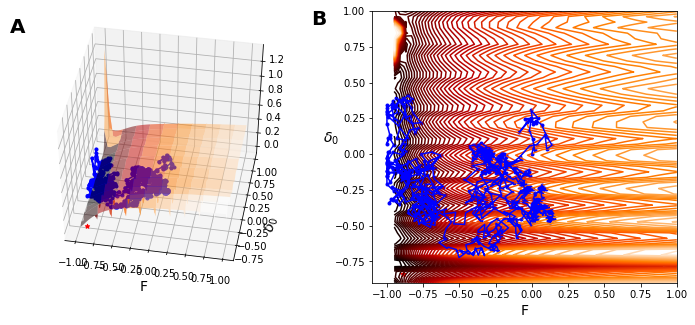

In [64]:
import numpy as np
import matplotlib.pyplot as  plt

# General path plotting function
def plot_states(states, costs, strings=["A", "B"]):
  sampling = 50

  F_3d = np.linspace(-0.95, 1, sampling)
  d0_3d = np.linspace(-0.90, 1, sampling)
  F_mesh, d0_mesh = np.meshgrid(F_3d, d0_3d)

  # Precalculated 
  loss = np.load(path + "Inverse design Fabry-Pérot/loss_trans.npy")

  fig = plt.figure(figsize = (12, 5))

  #Surface plot
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.plot_surface(F_mesh, d0_mesh, loss, rstride = 5, cstride = 5, cmap = 'gist_heat', alpha = 0.5, edgecolor = 'none')
  ax.scatter(Fd_true[0], Fd_true[1], 0, color = 'r', marker = '*')
  ax.scatter([state[0] for state in states], [state[1] for state in states], costs, color = 'b', marker='.')
  ax.plot([state[0] for state in states], [state[1] for state in states], costs, color = 'b', marker='.')

  ax.view_init(45, 280)
  ax.set_xlabel('F', fontsize=14)
  ax.set_ylabel('$\delta_0$', fontsize=14)
  ax.text(-0.1, 1.1, 10.5, strings[0], transform=ax.transAxes, 
            size=20, weight='bold')

  #Contour plot
  ax = fig.add_subplot(1, 2, 2)
  ax.contour(F_mesh, d0_mesh, np.clip(loss, a_min=0, a_max=0.5), 50, cmap = 'gist_heat')
  ax.scatter(Fd_true[0], Fd_true[1], color = 'r', marker = '*')
  ax.scatter([state[0] for state in states], [state[1] for state in states], color = 'b', marker='.')
  ax.plot([state[0] for state in states], [state[1] for state in states], color = 'b')
  ax.set_xlabel("F", fontsize=14)
  ax.set_ylabel("$\delta_0$", fontsize=14, rotation=0)
  ax.text(-0.2, 0.95, strings[1], transform=ax.transAxes, 
            size=20, weight='bold')

  plt.show()

# Plotting basic annealing
plot_states(states, costs)

Path length: 148.37384127773444


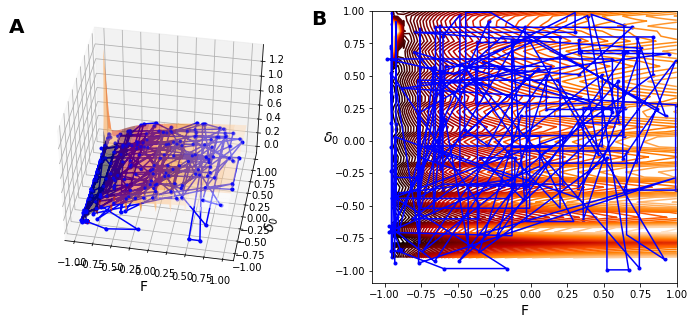

In [65]:
# Plot dual annealing path
dual_states_costs = np.load(path + "Inverse design Fabry-Pérot/dual_annealing_path.npy")
dual_states = dual_states_costs[:, :2]
dual_costs = dual_states_costs[:, 2]
plot_states(dual_states, dual_costs)

# Calculate path length
def path_length(states):
  dx = np.diff(states[:, 0])
  dy = np.diff(states[:, 1])
  ds = np.sqrt(dx**2 + dy**2)
  length = np.sum(ds)
  return length

print(f"Path length: {path_length(dual_states)}") 

Path length (fft): 1.7713356708293535
Path length (dual annealing): 148.37384127773444


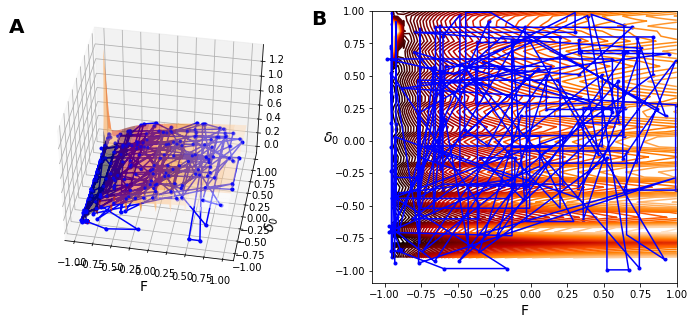

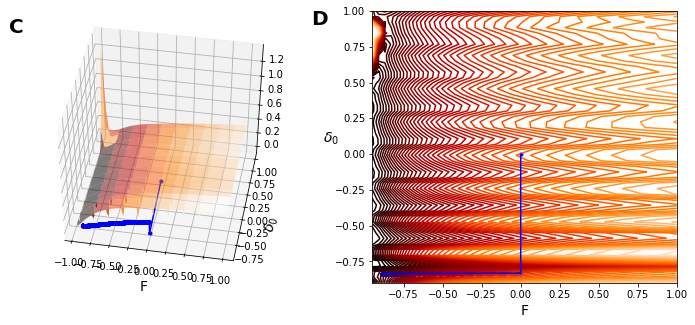

In [66]:
# Plot fft path
fft_states_costs = np.load(path + "Inverse design Fabry-Pérot/fft_path.npy")
fft_states = fft_states_costs[:, :2]
fft_costs = fft_states_costs[:, 2]
plot_states(dual_states, dual_costs)
plot_states(fft_states, fft_costs, strings=["C", "D"])

# Calculate path length
print(f"Path length (fft): {path_length(fft_states)}")
print(f"Path length (dual annealing): {path_length(dual_states)}")

In [67]:
# Loop over transmissions in the test set

def init_csv_design(savename):
  df = pd.DataFrame(columns=["Number", "F true", "F guess", "d true", "d guess",
                             "MAE spectrum"])
  df.to_csv(path + savename)

def add_row_to_csv(row, savename):
  df = pd.read_csv(path + savename, index_col=0)
  df = df.append(row, ignore_index=True)
  df.to_csv(path + savename)

def sim_ann(i, savename, verbose):
  if i % 50 == 0:
    print(f"Simulated annealing on transmission {i}")
  Fd_true = Fd_test[i]
  y_true = y_test[i]
  
  state, cost, states, costs = annealing(cost_function=cost_function_analytic, random_neighbour=random_neighbour, 
                                         acceptance_probability=acceptance_probability, 
                                         temperature=temperature, maxsteps=1000, debug=False);
 
  Fd_guess = state
  mae_guess = np.sqrt(cost)

  row = pd.Series(index=["Number", "F true", "F guess", "d true", "d guess", 
                         "MAE spectrum"],
                  data= [i, Fd_true[0], Fd_guess[0], Fd_true[1], Fd_guess[1],
                         mae_guess])
  add_row_to_csv(row, savename)

  if verbose:
    np.set_printoptions(precision=5)
    print(f"True parameters: {Fd_true}")
    print(f"Simulated annealing: {Fd_guess}")
    print(f"MAE: {mae_guess}\n")

def dual_ann(i, savename, verbose):
  if i % 50 == 0:
    print(f"Dual annealing on transmission {i}")
  Fd_true = Fd_test[i]
  y_true = y_test[i]
  
  ret = dual_annealing(cost_function, bounds=[(-1., 1.), (-1., 1.)], seed=0)

  Fd_guess = ret.x
  mae_guess = np.sqrt(ret.fun)

  row = pd.Series(index=["Number", "F true", "F guess", "d true", "d guess", 
                         "MAE spectrum"],
                  data= [i, Fd_true[0], Fd_guess[0], Fd_true[1], Fd_guess[1],
                         mae_guess])
  add_row_to_csv(row, savename)

  if verbose:
    np.set_printoptions(precision=5)
    print(f"True parameters: {Fd_true}")
    print(f"Simulated annealing: {Fd_guess}")
    print(f"MAE: {mae_guess}\n")

savename = "Nanophotonics paper/" + "dual_annealing_NN.csv"

#init_csv_design(savename)
for i in range(1000):
  y_true = y_test[i]
  #dual_ann(i, savename, verbose=False)

## Quantitative results

<Figure size 504x432 with 0 Axes>

(array([[945.,  14.,   9.,  20.,  10.,   2.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [982.,  12.,   1.,   2.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  1.,   6.,   5.,   2.,   5.,   5.,   6.,   6.,   3.,   6.,  14.,
          14.,  15.,  18.,  19.,  28.,  25.,  48.,  61.,  74.,  60.,  75.,
          55.,  60.,  58.]]),
 array([0.  , 0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19,
        0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41,
        0.43, 0.45, 0.47, 0.49]),
 <a list of 3 Lists of Patches objects>)

Text(0, 0.5, 'Counts')

Text(0.5, 0, 'MAE')

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 7 Text major ticklabel objects>)

([<matplotlib.axis.XTick at 0x7f7505a33a58>,
 <a list of 5 Text major ticklabel objects>)

(0.0, 1010.0)

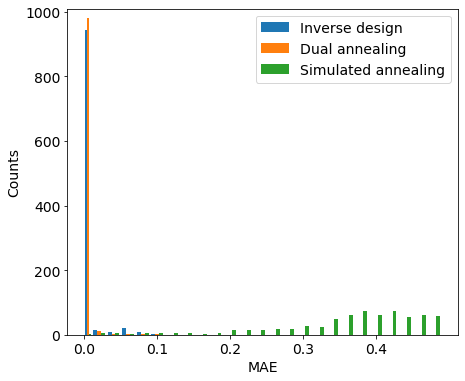

Global minima found with inverse design: 945/1000
Global minima found with dual annealing: 982/1000


In [87]:
import pandas as pd
import seaborn as sns

%matplotlib inline

path_exp = "Nanophotonics paper/"

res_dual = pd.read_csv(path + path_exp + "dual_annealing_NN.csv", index_col=0)
res_sim = pd.read_csv(path + path_exp + "simulated_annealing.csv", index_col=0)
res_four = pd.read_csv(path + path_exp + "Inverse design - fourier.csv", index_col=0)

res_four['diff MAE'] = res_four['MAE spectrum'] - res_four['MAE ground truth']
res_dual['diff MAE'] = res_dual['MAE spectrum'] - res_four['MAE ground truth']

plt.figure(figsize=(7, 6))
plt.hist([res_four["diff MAE"].clip(lower=0), res_dual["diff MAE"][:1000].clip(lower=0), res_sim["MAE spectrum"][:1000]], 
         bins=np.array([0] + [0.01 + 0.02*i for i in range(25)]),
         label=["Inverse design", "Dual annealing", "Simulated annealing"])
plt.ylabel("Counts", fontsize=14)
plt.xlabel("MAE", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0, 1010)

plt.show()

print(f"Global minima found with inverse design: {res_four[res_four['diff MAE'] < 0.01].count()[0]}/1000")
print(f"Global minima found with dual annealing: {res_dual[:1000][res_dual[:1000]['diff MAE'] < 0.01].count()[0]}/1000")